In [1]:
import numpy as np 
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image
import gdown

In [16]:
#Used for data augmentation (horizontal flip). The archive is already downloaded with the images

#import glob
#db_path = "Gender Recognition Images/"
#woman = [cv2.imread(file) for file in glob.glob(db_path+"woman/*.*")]
#for n in range(len(woman)):
#    cv2.imwrite("C:/Users/Nicho/OneDrive/Desktop/UNI/MAGISTRALE/Visione Artificiale/FER-and-GR-Project/Gender Recognition Images/woman/w{}.jpg".format(n),cv2.flip(woman[n],1))

In [108]:
file_path = "test.zip"

gdown.download("https://drive.google.com/uc?id=1JPgasvr1db3boCrnuSDRzXCXbbhptQ0h", file_path)
gdown.extractall(file_path)
if os.path.exists(file_path):
    os.remove(file_path)

gdown.download("https://drive.google.com/uc?id=1o1aX8fPCUFL8r6B-jsQtsbIUyuLc8Cge", file_path)
gdown.extractall(file_path)
if os.path.exists(file_path):
    os.remove(file_path)

gdown.download("https://drive.google.com/uc?id=1agaBydG4SR_HiUisGQBv7k8PkmUTHW61", file_path)
gdown.extractall(file_path)
if os.path.exists(file_path):
    os.remove(file_path)

Downloading...
From: https://drive.google.com/uc?id=1JPgasvr1db3boCrnuSDRzXCXbbhptQ0h
To: C:\Users\Nicho\OneDrive\Desktop\UNI\MAGISTRALE\Visione Artificiale\FER-and-GR-Project\test.zip
100%|██████████| 13.7M/13.7M [00:03<00:00, 4.41MB/s]
Downloading...
From: https://drive.google.com/uc?id=1o1aX8fPCUFL8r6B-jsQtsbIUyuLc8Cge
To: C:\Users\Nicho\OneDrive\Desktop\UNI\MAGISTRALE\Visione Artificiale\FER-and-GR-Project\test.zip
100%|██████████| 173M/173M [00:40<00:00, 4.28MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1agaBydG4SR_HiUisGQBv7k8PkmUTHW61
To: C:\Users\Nicho\OneDrive\Desktop\UNI\MAGISTRALE\Visione Artificiale\FER-and-GR-Project\test.zip
100%|██████████| 461M/461M [01:45<00:00, 4.37MB/s] 


In [28]:
db_path = "Gender Recognition Images/"
batch_size = 128
num_classes = 2
img_height = 378
img_width = 378

In [29]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(db_path,
                                                               validation_split=0.25,
                                                               subset="training",
                                                               seed=0,
                                                               label_mode = 'int',
                                                               color_mode='grayscale',
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(db_path,
                                                               validation_split=0.25,
                                                               subset="validation",
                                                               seed=0,
                                                               label_mode = 'int',
                                                               color_mode='grayscale',
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)


Found 30830 files belonging to 2 classes.
Using 23123 files for training.
Found 30830 files belonging to 2 classes.
Using 7707 files for validation.


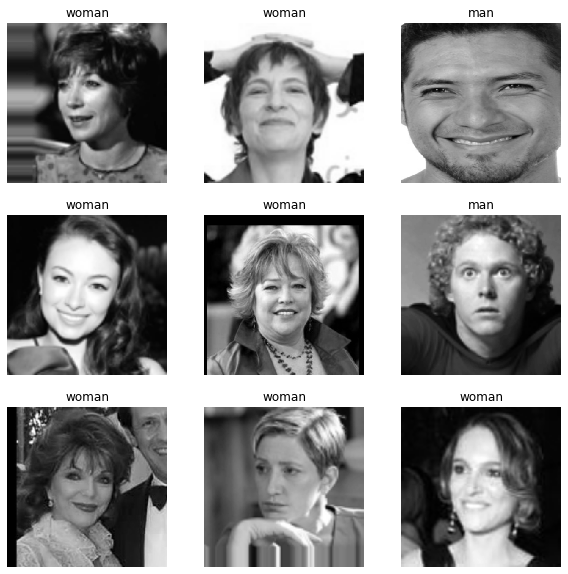

In [14]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        ax.imshow(images[i].numpy().astype("uint8")[:,:,0], cmap="gray")
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [18]:
# Build the Model

model = Sequential([
                  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,1)),
                  layers.Conv2D(32, 3, padding='same', activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(64, 3, padding='same', activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(128, 3, padding='same', activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Dropout(0.2),
                  layers.Conv2D(256, 3, padding='same', activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Dropout(0.2),
                  layers.Conv2D(512, 3, padding='same', activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Dropout(0.2),
                  layers.Flatten(),
                  layers.Dense(256, activation='relu'),
                  layers.Dropout(0.2),  
                  layers.Dense(128, activation = 'relu'),
                  layers.Dense(num_classes, activation = 'sigmoid')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3,
                                                  mode='min',
                                                  restore_best_weights=True
                                                 )

filepath = 'model_3.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                      monitor="val_loss",
                                                      save_best_only=True,
                                                      save_weights_only=False,
                                                      mode="min",
                                                      save_freq="epoch",
                                                    )

In [30]:
# Train the model

epochs = 50
history = model.fit(train_ds, validation_data = val_ds, epochs = epochs, batch_size = 128, 
                    verbose = 2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
181/181 - 96s - loss: 0.4134 - accuracy: 0.8023 - val_loss: 0.3513 - val_accuracy: 0.8483
Epoch 2/50
181/181 - 85s - loss: 0.3046 - accuracy: 0.8614 - val_loss: 0.2499 - val_accuracy: 0.8976
Epoch 3/50
181/181 - 87s - loss: 0.2289 - accuracy: 0.9032 - val_loss: 0.2110 - val_accuracy: 0.9151
Epoch 4/50
181/181 - 96s - loss: 0.1832 - accuracy: 0.9249 - val_loss: 0.2126 - val_accuracy: 0.9170
Epoch 5/50
181/181 - 89s - loss: 0.1438 - accuracy: 0.9423 - val_loss: 0.1747 - val_accuracy: 0.9355
Epoch 6/50
181/181 - 88s - loss: 0.1142 - accuracy: 0.9565 - val_loss: 0.2098 - val_accuracy: 0.9292
Epoch 7/50
181/181 - 87s - loss: 0.1015 - accuracy: 0.9610 - val_loss: 0.2009 - val_accuracy: 0.9302
Epoch 8/50
181/181 - 88s - loss: 0.0812 - accuracy: 0.9687 - val_loss: 0.2111 - val_accuracy: 0.9292


In [31]:
model_acc = model.evaluate(val_ds)[1]
model_acc

61/61 [==============================] - ETA: 1:50 - loss: 0.1754 - accuracy: 0.93 - ETA: 10s - loss: 0.1853 - accuracy: 0.9297 - ETA: 10s - loss: 0.1741 - accuracy: 0.929 - ETA: 10s - loss: 0.1839 - accuracy: 0.935 - ETA: 10s - loss: 0.1809 - accuracy: 0.932 - ETA: 9s - loss: 0.1764 - accuracy: 0.931 - ETA: 9s - loss: 0.1758 - accuracy: 0.93 - ETA: 9s - loss: 0.1754 - accuracy: 0.93 - ETA: 9s - loss: 0.1681 - accuracy: 0.93 - ETA: 8s - loss: 0.1752 - accuracy: 0.93 - ETA: 8s - loss: 0.1883 - accuracy: 0.93 - ETA: 8s - loss: 0.1806 - accuracy: 0.93 - ETA: 8s - loss: 0.1828 - accuracy: 0.93 - ETA: 8s - loss: 0.1852 - accuracy: 0.93 - ETA: 8s - loss: 0.1913 - accuracy: 0.93 - ETA: 7s - loss: 0.1922 - accuracy: 0.93 - ETA: 7s - loss: 0.1884 - accuracy: 0.93 - ETA: 7s - loss: 0.1896 - accuracy: 0.93 - ETA: 7s - loss: 0.1914 - accuracy: 0.93 - ETA: 7s - loss: 0.1878 - accuracy: 0.93 - ETA: 6s - loss: 0.1886 - accuracy: 0.93 - ETA: 6s - loss: 0.1921 - accuracy: 0.93 - ETA: 6s - loss: 0.1881 

0.9355131983757019

In [40]:
# Save the Model

https://drive.google.com/file/d/1easVnhBN9o1s60_eAyl8CGj_LHuPoXgc/view?usp=sharing

model.save('Gender Model/')

INFO:tensorflow:Assets written to: Gender Model/assets


In [41]:
#Load the Model
file_path = "test.zip"

gdown.download("https://drive.google.com/uc?id=1easVnhBN9o1s60_eAyl8CGj_LHuPoXgc", file_path)
gdown.extractall(file_path)
if os.path.exists(file_path):
    os.remove(file_path)
model = keras.models.load_model('Gender Model/')

Downloading...
From: https://drive.google.com/uc?id=1easVnhBN9o1s60_eAyl8CGj_LHuPoXgc
To: C:\Users\Nicho\OneDrive\Desktop\UNI\MAGISTRALE\Visione Artificiale\FER-and-GR-Project\test.zip
100%|██████████| 144M/144M [00:31<00:00, 4.54MB/s] 


woman


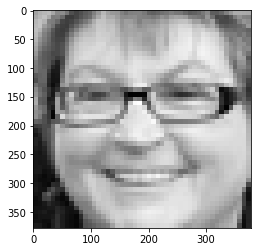

In [48]:
# Load and Predict an image

img = image.load_img("Emotions Test Set/100.png", target_size=(img_height,img_width), color_mode = "grayscale")
plt.imshow(img, cmap="gray")
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images)
print(class_names[np.where(classes > 0.5, 1,0)[0][1]])

In [39]:
cap = cv2.VideoCapture(0)

if (cap.isOpened() == False): 
    print("Unable to read camera feed")

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

#out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
 
while(True):
    ret, frame = cap.read()

    if ret == True: 
        #out.write(frame)
        cv2.imshow('frame',frame)
        resized = cv2.cvtColor(cv2.resize(frame, (img_height,img_width)), cv2.COLOR_RGB2GRAY)
        x = image.img_to_array(resized)
        x = np.expand_dims(x, axis=0)
        images = np.vstack([x])
        classes = model.predict(images)
        print(class_names[np.where(classes > 0.5, 1,0)[0][1]])
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break 

cap.release()
#out.release()
 
# Closes all the frames
cv2.destroyAllWindows()

man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
man
